In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math




In [36]:
excel_file_path = 'budgetusd.xlsx'
sheet_name = "Revenue"
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)


# Load the Excel file into a pandas DataFrame



In [37]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)

In [38]:
# Repace Yes/No/Medium values from Winter North and Rainy Season variables

column_replacements = {
    'Winter North': {"Yes": 1, "No": 0},
    'Local Rainy Season': {"No": 0, "Medium": 1, "Yes": 2}  # Map integer 1 to 1 and string values to appropriate numbers
}
for col, replacements in column_replacements.items():
    df[col] = df[col].replace(replacements)

In [39]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Percentage Rooms Occ %  24 non-null     float64
 1   Percentage F&B Occ %    24 non-null     float64
 2   Holidays Local          24 non-null     float64
 3   Winter North            24 non-null     int64  
 4   Holidays North          24 non-null     float64
 5   Local Rainy Season      24 non-null     int64  
 6   International Flights   24 non-null     float64
 7   Marketing               24 non-null     float64
 8   Average Price F&B       24 non-null     float64
 9   Average Room Rate       24 non-null     float64
 10  Number of Rooms         24 non-null     float64
 11  Rooms Revenue           24 non-null     float64
 12  F&B Revenue             24 non-null     float64
 13  Total Revenue           24 non-null     float64
dtypes: float64(12), int64(2)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['Rooms Revenue'], axis=1),
                                        df['Rooms Revenue'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)  

* Train set: (19, 13) (19,) 
* Test set: (5, 13) (5,)


In [42]:
from sklearn.ensemble import RandomForestRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
    ])
    return pipeline

# Define the parameter grid with the correct parameter name
param_grid = {"model__n_estimators": [10, 20]}

# Create the pipeline
pipeline = pipeline_random_forest_reg()

# Create the GridSearchCV object
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    cv=2,
                    n_jobs=-2,
                    verbose=3,
                    scoring='r2')

# Fit the GridSearchCV to perform hyperparameter tuning
grid.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END ............model__n_estimators=10;, score=0.656 total time=   0.2s
[CV 2/2] END ............model__n_estimators=10;, score=0.690 total time=   0.3s
[CV 1/2] END ............model__n_estimators=20;, score=0.697 total time=   0.3s
[CV 2/2] END ............model__n_estimators=20;, score=0.803 total time=   0.3s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                                       ('model',
                                        RandomForestRegressor(random_state=101))]),
             n_jobs=-2, param_grid={'model__n_estimators': [10, 20]},
             scoring='r2', verbose=3)

In [43]:
grid.cv_results_

{'mean_fit_time': array([0.21336889, 0.26095915]),
 'std_fit_time': array([0.00139308, 0.01634622]),
 'mean_score_time': array([0.03536808, 0.02998543]),
 'std_score_time': array([0.0241257 , 0.01507258]),
 'param_model__n_estimators': masked_array(data=[10, 20],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__n_estimators': 10}, {'model__n_estimators': 20}],
 'split0_test_score': array([0.65639356, 0.69661527]),
 'split1_test_score': array([0.69011084, 0.80345316]),
 'mean_test_score': array([0.6732522 , 0.75003421]),
 'std_test_score': array([0.01685864, 0.05341894]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [44]:
(pd.DataFrame(grid.cv_results_)
.sort_values(by="mean_test_score", ascending=False)
.filter(['params', 'mean_test_score'])
.values
)

array([[{'model__n_estimators': 20}, 0.7500342133650332],
       [{'model__n_estimators': 10}, 0.6732522016845439]], dtype=object)

In [45]:
grid.best_params_

{'model__n_estimators': 20}

In [46]:
pipeline = grid.best_estimator_
pipeline

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model',
                 RandomForestRegressor(n_estimators=20, random_state=101))])

In [47]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.963
Mean Absolute Error: 556.183
Mean Squared Error: 518501.019
Root Mean Squared Error: 720.07


* Test Set
R2 Score: 0.873
Mean Absolute Error: 1470.876
Mean Squared Error: 2290556.869
Root Mean Squared Error: 1513.459




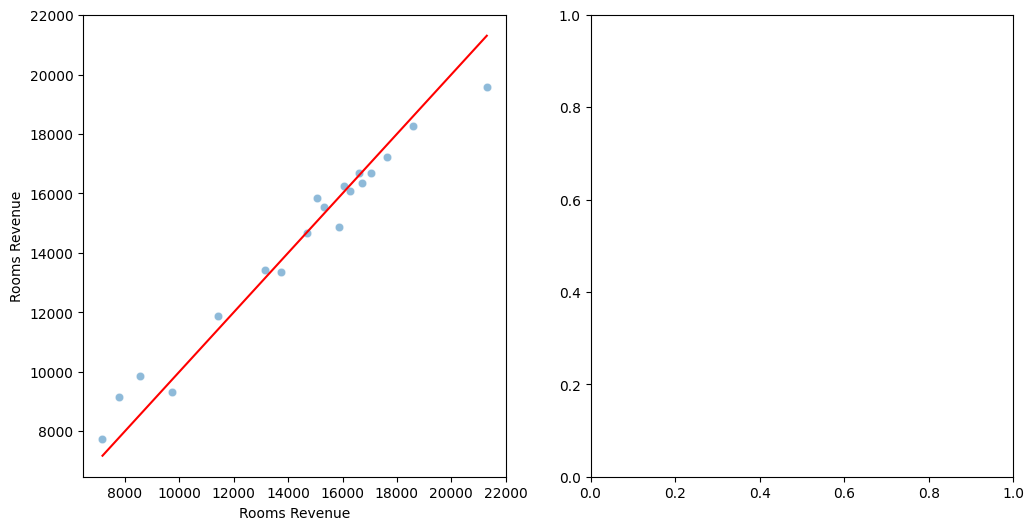

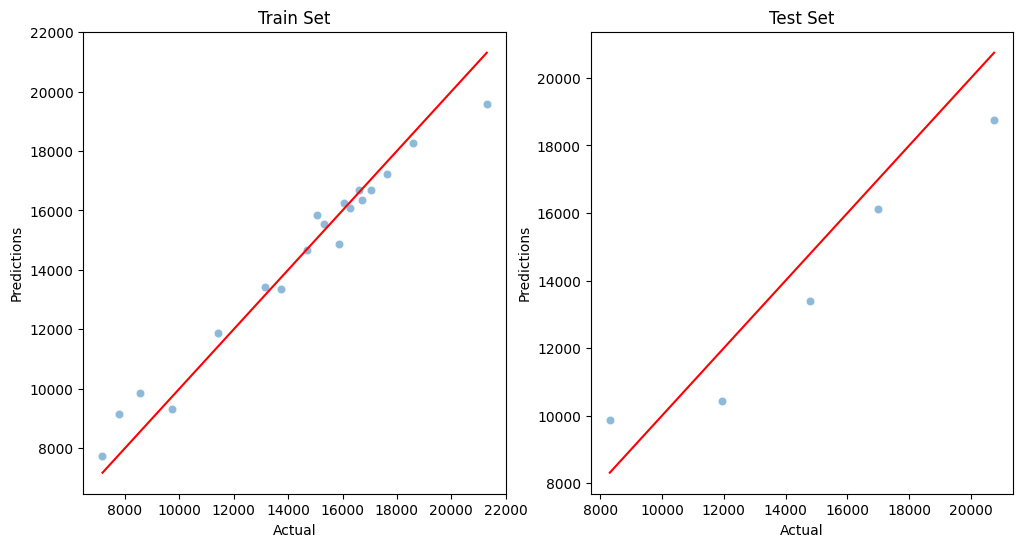

In [48]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

In [49]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

# Create Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
ridge_model.fit(X_train, y_train)

# Create Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
lasso_model.fit(X_train, y_train)

# Predictions using Ridge and Lasso models
ridge_predictions = ridge_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)

# Evaluate performance using R2 score
ridge_r2 = r2_score(y_test, ridge_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("R2 Score for Ridge Regression:", ridge_r2)
print("R2 Score for Lasso Regression:", lasso_r2)


R2 Score for Ridge Regression: 0.9999999999976473
R2 Score for Lasso Regression: 0.9999999843828502


In [50]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor for feature selection
rf_model = RandomForestRegressor(random_state=101)
rf_model.fit(X_train, y_train)

# Create a SelectFromModel instance
feature_selector = SelectFromModel(rf_model, threshold="median")

# Fit the feature selector on the training data
feature_selector.fit(X_train, y_train)

# Transform the training and test data
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# Now you can use X_train_selected and X_test_selected for model training and evaluation


* These are the 13 most important features in descending order. The model was trained on them:
['Total Revenue', 'F&B Revenue', 'Percentage Rooms Occ %', 'Marketing', 'Percentage F&B Occ %', 'Average Price F&B', 'Local Rainy Season', 'Holidays Local', 'International Flights', 'Winter North', 'Average Room Rate', 'Holidays North', 'Number of Rooms']


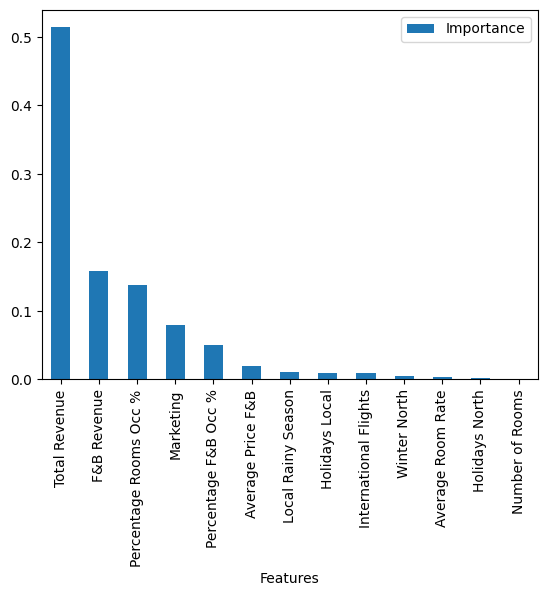

In [51]:
def feature_importance_random_forest(model, columns):
    """ Gets the model and the columns used to train the model.
    Uses the model's feature_importances_ and columns to create a DataFrame
    that shows the importance of each feature. Then, it prints the feature names
    and their relative importance order, followed by a barplot indicating the importance.
    """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

# Call the function with your trained RandomForest model and feature columns
feature_importance_random_forest(rf_model, X_train.columns)
